In [1]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = r"D:\cangku\data"
FILES = [
    "gpp_Lmon_CanESM5_abrupt-4xCO2_185001-200012.nc",
    "gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912.nc",
    "gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912.nc",
]

# 目标规则网格（1x1度，中心点）
tgt_lat = np.arange(-89.5, 90.5, 1.0)
tgt_lon = np.arange(0.5, 360.5, 1.0)
# 常量
R = 6_371_000.0  # 地球半径 (m)
deg2rad = np.pi / 180.0
dphi = 1.0 * deg2rad  # 1° in rad
dlam = 1.0 * deg2rad

In [3]:
def to_0_360(lon):
    """把经度统一为 [0, 360)"""
    lon = lon % 360
    return lon

def make_target_grid():
    return xr.Dataset(
        coords=dict(lat=("lat", tgt_lat), lon=("lon", tgt_lon))
    )

def cell_area_1x1(lat_vals):
    """
    规则1x1度网格的格点面积（m^2），随纬度变化。
    area(lat) = R^2 * dphi * dlam * cos(lat)
    返回 (lat, lon) 二维数组（lon 方向相同复制）
    """
    coslat = np.cos(lat_vals * deg2rad)
    band_area = (R**2) * dphi * dlam * coslat  # 每个经度带每格面积
    area2d = np.repeat(band_area[:, None], tgt_lon.size, axis=1)
    return xr.DataArray(area2d, coords={"lat": tgt_lat, "lon": tgt_lon}, dims=("lat", "lon"))

def monthly_to_monthsum_if_needed(gpp):
    """
    如果 gpp 单位包含 's-1'（常见是 kg m-2 s-1 的月平均通量），
    则按每月秒数积分到“kg m-2 per month”。
    若原本已是月累计（单位里不含 s-1），则直接返回。
    """
    units = str(gpp.attrs.get("units", "")).lower()
    if "s-1" in units or "/s" in units:
        # 每月秒数（考虑不同月天数）
        sec_per_month = (gpp["time"].dt.days_in_month * 24 * 3600).astype("int64")
        # 对齐维度 (time, 1, 1)
        sec_per_month = sec_per_month.broadcast_like(gpp.isel(lat=0, lon=0)).drop_vars(["lat", "lon"])
        gpp_msum = gpp * sec_per_month
        gpp_msum.attrs["units"] = units.replace(" s-1", "").replace("/s", "")
        gpp_msum.attrs["note"] = "Converted from monthly-mean flux to monthly sum"
        return gpp_msum
    else:
        return gpp  # 视为已是月累计或月平均按月累计意义同等

In [4]:
def regrid_to_1x1(ds):
    """
    线性插值到1x1度规则网格。
    要求原始是规则经纬网（CanESM5 的 'gn' 一般可直接 interp）。
    """
    # 统一经度到 [0, 360)
    if "lon" in ds:
        # 处理 lon wrap
        lon = ds["lon"].values
        # 若是 [-180, 180)，转到 [0, 360)
        if np.any(lon < 0):
            ds = ds.assign_coords(lon=((ds["lon"] + 360) % 360)).sortby("lon")
    target = make_target_grid()
    # 线性插值
    ds_regrid = ds.interp(lat=tgt_lat, lon=tgt_lon, method="linear")
    return ds_regrid

def annual_tropical_total_gpp(nc_path, label):
    """
    读取单个文件，返回 1850–1949 年的热带(40S–40N)年累计总GPP（kg/yr）时间序列。
    """
    ds = xr.open_dataset(nc_path, decode_times=True)

    # 取 gpp 变量
    varname = "gpp"
    if varname not in ds:
        raise ValueError(f"{nc_path} 不含变量 '{varname}'")
    da = ds[varname]

    # 插值到1x1度
    da_rg = regrid_to_1x1(da.to_dataset(name="gpp"))["gpp"]

    # 如需，把月平均通量变为“月累计”
    da_msum = monthly_to_monthsum_if_needed(da_rg)

    # 选择热带纬度
    da_trop = da_msum.sel(lat=slice(-40, 40))

    # 计算1x1格点面积 (lat, lon)
    area = cell_area_1x1(tgt_lat).sel(lat=slice(-40, 40))

    # 把单位从“kg m-2 per month” 乘面积 → “kg per month”
    # 广播相乘
    gpp_monthly_total = da_trop * area

    # 逐年（1–12月）累加：得到“kg per year”
    gpp_annual_total = gpp_monthly_total.groupby("time.year").sum("time")

    # 选取 1850–1949 年
    gpp_1850_1949 = gpp_annual_total.sel(year=slice(1850, 1949))

    # 设定属性
    gpp_1850_1949.name = label
    gpp_1850_1949.attrs["units"] = "kg per year over 40S–40N"
    ds.close()
    return gpp_1850_1949

In [5]:
def main():
    series = []
    mapping = {
        "abrupt-4xCO2": "abrupt-4xCO2",
        "G1": "G1",
        "piControl": "piControl",
    }
    for fname in FILES:
        path = os.path.join(DATA_DIR, fname)
        if not os.path.exists(path):
            print(f"⚠️ 找不到文件：{path}")
            continue
        # 自动判断标签
        label = None
        for key, lab in mapping.items():
            if key.lower() in fname.lower():
                label = lab
                break
        if label is None:
            label = os.path.splitext(fname)[0]
        ser = annual_tropical_total_gpp(path, label)
        series.append(ser)

    if not series:
        print("没有可用数据。")
        return

    # 合并到一个 DataArray/Dataset 便于画图
    ds_plot = xr.concat(series, dim="experiment").assign_coords(experiment=[s.name for s in series])

    # 画图
    plt.figure(figsize=(9, 5))
    for i, exp in enumerate(ds_plot["experiment"].values):
        y = ds_plot.sel(experiment=exp)
        plt.plot(y["year"], y, label=str(exp))
    plt.title("Tropical (40S–40N) Annual GPP (1x1°, 1850–1949)\nCanESM5")
    plt.xlabel("Year")
    plt.ylabel("Total GPP (kg / year)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

ValueError: These variables cannot be found in this dataset: ['lat', 'lon']

[Open] gpp_Lmon_CanESM5_abrupt-4xCO2_185001-200012.nc
[Open] gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912.nc
[Open] gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912.nc
[Saved] D:\cangku\data\tropical_GPP_1850_1949.png
Done.


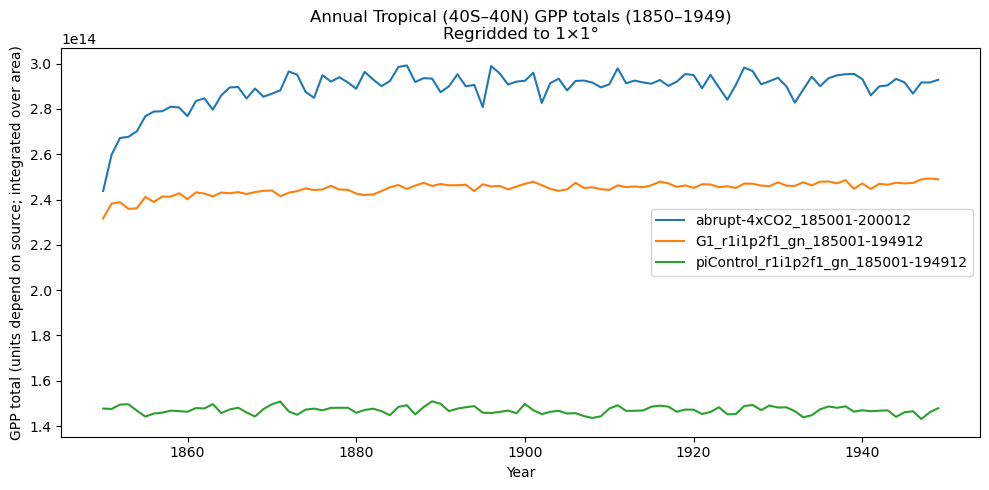

In [7]:

"""
Compute annual tropical (40S–40N) GPP totals from monthly CanESM5 files.
Steps:
1) Read all target files from D:\cangku\data
2) Regrid to 1x1° using lat/lon from gpp_abrupt-4xCO2_CanESM5_mask_1x1.nc
3) For each file, sum months (Jan–Dec) to annual totals (time-integrated using days_in_month if units are per second)
4) Integrate over 40S–40N using spherical cell areas
5) Plot 1850–1949 annual tropical GPP time series for each experiment
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# -------------------- User paths --------------------
DATA_DIR = Path(r"D:\cangku\data")
MASK_FILE = DATA_DIR / "gpp_abrupt-4xCO2_CanESM5_mask_1x1.nc"

# Specific files (will only process those that exist)
TARGET_FILES = [
    "gpp_Lmon_CanESM5_abrupt-4xCO2_185001-200012.nc",
    "gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912.nc",
    "gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912.nc",
]

# -------------------- Helpers --------------------
def fix_lon_to_180(ds, lon_name="lon"):
    """Convert longitudes to [-180, 180) and sort, if needed."""
    if lon_name in ds.coords:
        lon = ds[lon_name]
    elif lon_name in ds.dims:
        lon = ds[lon_name]
    else:
        return ds  # no lon found
    lon_new = ((lon + 180) % 360) - 180
    ds = ds.assign_coords({lon_name: lon_new})
    ds = ds.sortby(lon_name)
    return ds

def find_gpp_var(ds):
    """Return the name of the GPP variable (contains 'gpp' case-insensitive)."""
    for v in ds.data_vars:
        if "gpp" in v.lower():
            return v
    raise ValueError("No variable containing 'gpp' found in dataset.")

def compute_cell_area_1x1(lat_1d, lon_1d):
    """Compute spherical cell areas (m^2) for a regular 1x1° grid given 1D lat/lon arrays."""
    R = 6371000.0  # Earth radius [m]
    dlat = np.deg2rad(np.abs(np.diff(lat_1d).mean()) if lat_1d.size > 1 else 1.0)
    dlon = np.deg2rad(np.abs(np.diff(lon_1d).mean()) if lon_1d.size > 1 else 1.0)

    # cell bounds by +/- 0.5 grid spacing
    lat_rad = np.deg2rad(lat_1d.values)
    # use half-step based on dlat
    lat_bnds_upper = lat_rad + dlat/2.0
    lat_bnds_lower = lat_rad - dlat/2.0
    strip_area = R**2 * dlon * (np.sin(lat_bnds_upper) - np.sin(lat_bnds_lower))  # shape (lat,)
    # broadcast to (lat, lon)
    area_2d = xr.DataArray(
        np.outer(strip_area, np.ones(lon_1d.size)),
        coords={"lat": lat_1d, "lon": lon_1d},
        dims=("lat", "lon"),
        name="cell_area",
        attrs={"units": "m2"}
    )
    return area_2d

def to_annual_integrated(da):
    """
    Convert monthly GPP to annual totals.
    If units contain 's-1' (i.e., a rate), multiply by seconds per month before summing.
    Otherwise, do a straight monthly sum.
    """
    units = (da.attrs.get("units") or "").lower()
    if "s-1" in units or "s^-1" in units or "/s" in units:
        # time-integrate monthly means
        seconds = (da["time"].dt.days_in_month * 86400).astype("float64")
        # align for broadcasting
        da_monthly_total = da * seconds
    else:
        da_monthly_total = da
    annual = da_monthly_total.groupby("time.year").sum("time")
    return annual

# -------------------- Load target 1x1° grid --------------------
if not MASK_FILE.exists():
    raise FileNotFoundError(f"Mask/grid file not found: {MASK_FILE}")
mask = xr.open_dataset(MASK_FILE)
# try common coord names
lat_name = "lat" if "lat" in mask.coords else ("latitude" if "latitude" in mask.coords else "lat")
lon_name = "lon" if "lon" in mask.coords else ("longitude" if "longitude" in mask.coords else "lon")
mask = fix_lon_to_180(mask, lon_name=lon_name)
lat_tgt = mask[lat_name]
lon_tgt = mask[lon_name]

# Precompute cell areas on the 1x1 grid (lat,lon)
area = compute_cell_area_1x1(lat_tgt, lon_tgt)

# -------------------- Process each file --------------------
results = {}  # {label: pandas.Series of annual totals}

for fname in TARGET_FILES:
    fpath = DATA_DIR / fname
    if not fpath.exists():
        # skip missing files silently but inform at the end
        print(f"[Skip] File not found: {fpath}")
        continue

    print(f"[Open] {fpath.name}")
    ds = xr.open_dataset(fpath, decode_times=True)

    # Harmonize lon to [-180, 180)
    ds = fix_lon_to_180(ds, lon_name=lon_name if lon_name in ds.coords else ("lon" if "lon" in ds.coords else list(ds.coords)[0]))

    # Identify GPP variable
    gpp_name = find_gpp_var(ds)
    gpp = ds[gpp_name]

    # Regrid to target 1x1 using linear interpolation
    # Ensure target lons match range with source
    # (both have been forced to [-180, 180))
    gpp_1x1 = gpp.interp({lat_name if lat_name in gpp.dims else "lat": lat_tgt,
                          lon_name if lon_name in gpp.dims else "lon": lon_tgt},
                         method="linear")

    # Select tropics
    gpp_tropics = gpp_1x1.sel({lat_name if lat_name in gpp_1x1.dims else "lat": slice(-40, 40)})

    # Annual integration
    gpp_annual = to_annual_integrated(gpp_tropics)

    # Area-integrate over 40S–40N
    # Align area with data dims (lat, lon)
    # Use xarray's weighted sum with explicit weights (area)
    # Mask out any NaNs to avoid propagating in sum
    area_tropics = area.sel(lat=slice(-40, 40))
    # ensure same coords names as data
    area_tropics = area_tropics.rename({ "lat": list(gpp_annual.dims)[-2] if "lat" in area_tropics.dims and "lat" not in gpp_annual.dims else "lat",
                                         "lon": list(gpp_annual.dims)[-1] if "lon" in area_tropics.dims and "lon" not in gpp_annual.dims else "lon"})
    # broadcast & multiply
    gpp_total = (gpp_annual * area_tropics).sum(dim=[d for d in gpp_annual.dims if d != "year"], skipna=True)

    # To pandas Series
    ser = gpp_total.to_series()
    # Keep 1850–1949 only (if available)
    ser = ser[(ser.index >= 1850) & (ser.index <= 1949)]
    label = fname.replace("gpp_Lmon_CanESM5_", "").replace(".nc", "")
    results[label] = ser

# -------------------- Plot --------------------
if not results:
    raise RuntimeError("No input files were found. Please check paths in DATA_DIR.")

plt.figure(figsize=(10, 5))
for label, ser in results.items():
    if len(ser) == 0:
        continue
    ser.sort_index().plot(label=label)
plt.title("Annual Tropical (40S–40N) GPP totals (1850–1949)\nRegridded to 1×1°")
plt.xlabel("Year")
plt.ylabel("GPP total (units depend on source; integrated over area)")
plt.legend()
plt.tight_layout()

# Save alongside data
out_png = DATA_DIR / "tropical_GPP_1850_1949.png"
plt.savefig(out_png, dpi=150)
print(f"[Saved] {out_png}")

print("Done.")
